# Text Classification with Naive Bayes & Logistic Regression

We are going to classify whether the sms messages are spam or ham using publicly available sms dataset.

The dataset can be accessible from [Kaggle SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

To resolve this problem, the following steps will be followed:


1.   Processing text into numerical format
2.   Bag of words approach
3.   Different pre-processing steps
4.   Model evaluation on imbalanced datasets



In [12]:
#@title Imports
# for Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# for models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# for evaluation
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             confusion_matrix, accuracy_score)

## for Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import wordcloud

# for preprocessing
import string

# for vectorizing
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# others
import pprint

## Get the Data

In [5]:
df_sms = pd.read_csv('/content/spam.csv',encoding='latin-1')
df_sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df_sms.columns

In [ ]:
df_sms.v2[8]

In [ ]:
df_sms.v1[8]

In [6]:
df_sms = df_sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df_sms = df_sms.rename(columns={"v1":"label", "v2":"df_sms"})
df_sms.head()

,label,df_sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print(len(df_sms))

## Exploratory Data Analysis

In [ ]:
df_sms.describe()

In [ ]:
df_sms.groupby('label').describe()

In [ ]:
df_sms['length'] = df_sms['sms'].apply(len)
df_sms.head()

### Data Visualization

In [ ]:
df_sms['length'].plot(bins=50,kind='hist')

In [ ]:
df_sms.hist(column='length', by='label', bins=50,figsize=(10,4))

In [ ]:
df_sms.pivot_table(index='label',values='length',aggfunc='mean')

Eventhough the length will not be used as an input to our model in this notebook, we can clearly receive insights that can be useful from exploratory analysis.

In [ ]:
#@title Encode labels
df_sms.loc[:,'label'] = df_sms['label'].map({'ham':0, 'spam':1})
df_sms.head()

In [ ]:
#@title Word Cloud
wc = wordcloud.WordCloud(background_color='white', max_words=100, 
                         max_font_size=35)
wc = wc.generate(" ".join(df_sms["df_sms"].tolist()))
fig = plt.figure(num=1,figsize=(8,8))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

## Dataset split to extract test set

In [ ]:
y = df_sms['label']
X = df_sms['sms']

X.head()

In [ ]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Train + validation set size: %d\nTest set size: %d" % (len(y_train_valid), len(y_test)))

### Splitting the train and validation data 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=1/9, random_state=42)

print("Train set size: %d\nValid set size: %d" % (len(y_train), len(y_valid)))

## Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model)(bag-of-unigrams) approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).


Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

### The steps to follow for a sample data

In [ ]:
documents = ['Hello, how are you!',
             'Win money, win from home.',
             'Call me now.',
             'Hello, Call hello you tomorrow?']

Step 1: Convert all strings to their lower case form.


> We don't want two hello features exist "Hello" and "hello"

> There are some exceptions though, "US" and "us"


In [ ]:
lower_case_documents = [d.lower() for d in documents]
print(lower_case_documents)

Step 2: Removing all punctuations

> Does not provide information in general






In [ ]:
string.punctuation

In [ ]:
punctuation_documents = []

for sent in lower_case_documents:
    #Translate applies the map
    #Maketrans provides the map, if three arguments are passed, each character in the third argument is mapped to None.
    punctuation_documents.append(sent.translate(str.maketrans("", "", string.punctuation)))
    
punctuation_documents

Step 3: Tokenization

In [ ]:
preprocessed_documents = [[w for w in d.split()] for d in punctuation_documents]
preprocessed_documents

Step 4: Count frequencies

In [ ]:
frequency_list = []

frequency_list = [Counter(d) for d in preprocessed_documents]
pprint.pprint(frequency_list)

### Implementing Bag of Words in scikit-learn

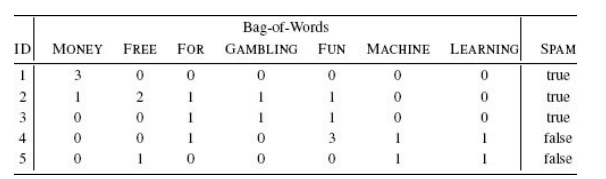

In [ ]:
count_vector = CountVectorizer()

CountVectorizer() has certain parameters which take care of these steps for us. They are:



```
lowercase = True
```




The lowercase parameter has a default value of True which converts all of our text to its lower case form.



```
token_pattern = (?u)\b\w\w+\b
```


The token_pattern parameter has a default regular expression value of (?u)\b\w\w+\b which ignores all punctuation marks and treats them as delimiters, while accepting alphanumeric strings of length greater than or equal to 2, as individual tokens or words.

```
stop_words
```

The stop_words parameter, if set to english will remove all words from our document set that match a list of English stop words which is defined in scikit-learn. Such as 'the', 'a', 'an', etc.




We will be experimenting the effects of these preprocessing steps during model selection


In [ ]:
count_vector.fit(documents)
count_vector.get_feature_names()

In [ ]:
len(count_vector.get_feature_names())

In [ ]:
doc_array = count_vector.transform(documents).toarray()
doc_array

To interpret this array better

In [ ]:
pd.DataFrame(doc_array, columns=count_vector.get_feature_names())

# Now we will apply this vectorization to our data with different pre-processing steps

## Model 1 - No lowercase and stopword removal

In [ ]:
X_train.head()

In [ ]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(lowercase=False)

# Fit the training data and then get the vectors
X_bow_train = count_vector.fit_transform(X_train)

# Transform validation and testing data without learning the statistics and get the matrix. 
X_bow_valid = count_vector.transform(X_valid)

In [ ]:
X_bow_train.toarray()[:5]

In [ ]:
X_bow_train.shape

Vocabulary

In [ ]:
print("The vocabulary size of our data is %d" % (X_bow_train.shape[1]))

We except many of the features are zeros but, how many of our matrix filled with non-zero?

In [ ]:
nonzero_feature_count = X_bow_train.nnz
total_feature_count = X_bow_train.shape[0]*X_bow_train.shape[1]

print("Non-zero features", nonzero_feature_count)
print("Total number of features (matrix size)", total_feature_count)
print("The percentage %%%.2f" % (100*nonzero_feature_count/total_feature_count))

The matrix that has very small portion of the values are non-zero called [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix). The data uses massive amount of memory filled with 0 values to represent small number of features. Besides the memory problem, the machine learning model performance suffers to correlate the features because of this sparsity issue.

There are various ways to decrease sparsity by cleaning, normalizing the data without loosing information.

In [ ]:
type(X_bow_train)

## Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We are using Multinomial Naive Bayes, since the occurence of one feature does not affect the probability of occurrence of the other feature in our task.

In parallel, we are going to train a Logistic Regression model to compare its performance with the Naive Bayes Model.

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_bow_train, y_train)

In [ ]:

lr = LogisticRegression()
lr.fit(X_bow_train, y_train)

### Model Evaluation

In [ ]:
y_pred_valid = naive_bayes.predict(X_bow_valid)

y_pred_valid_lr = lr.predict(X_bow_valid)

### Why not use accuracy?

In [ ]:
### Majority class voting
y_valid_majority = np.full(y_valid.shape, 0)

y_valid_majority

In [ ]:
accuracy_score(y_valid, y_valid_majority)

### Precision, Recall, F1-Score

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

The formulation:

## $ Accuracy = \frac{TP + TN}{Total}$
## $ Precision = \frac{TP}{TP + FP}$
## $ Recall = \frac{TP}{TP + FN}$
## $ F1 = 2\times\frac{1}{\frac{1}{Precision}+\frac{1}{Recall}}$

In [ ]:
print("Multinomial Naive Bayes Results:")
print("Precision:", precision_score(y_valid,y_pred_valid))
print("Recall:", recall_score(y_valid,y_pred_valid))
print("F1 Score:", f1_score(y_valid,y_pred_valid))
print("Confusion matrix:\n",confusion_matrix(y_valid,y_pred_valid))

In [ ]:
print("Logistic Regression Results:")
print("Precision:", precision_score(y_valid,y_pred_valid_lr))
print("Recall:", recall_score(y_valid,y_pred_valid_lr))
print("F1 Score:", f1_score(y_valid,y_pred_valid_lr))
print("Confusion matrix:\n",confusion_matrix(y_valid,y_pred_valid_lr))

There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".

Thus, our goal is to increase the f1-score and therefore the macro-average.

## Model 2 - Do lowercase and no stopword removal

In [ ]:
# Instantiate the CountVectorizer method, with default lowercase=True
count_vector = CountVectorizer()

# Fit the training data and then get the vectors
X_bow_train = count_vector.fit_transform(X_train)

# Transform validation and testing data without learning the statistics and get the matrix. 
X_bow_valid = count_vector.transform(X_valid)

In [ ]:
X_bow_train.shape

Our vocabulary size decreased from 9564 to 7699

How about the non-zero ratio?

In [ ]:
nonzero_feature_count = X_bow_train.nnz
total_feature_count = X_bow_train.shape[0]*X_bow_train.shape[1]

print("Non-zero features", nonzero_feature_count)
print("Total number of features (matrix size)", total_feature_count)
print("The percentage %%%.2f" % (100*nonzero_feature_count/total_feature_count))

Non-zero features 58770
Total number of features (matrix size) 34306744
The percentage %0.17


Our non-zero percentage increased from 


```
%0.14 -> %0.17
```

This can be interpreted as our data is less sparse


In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_bow_train, y_train)

In [ ]:
lr = LogisticRegression()
lr.fit(X_bow_train, y_train)

In [ ]:
y_pred_valid = naive_bayes.predict(X_bow_valid)

In [ ]:
y_pred_valid_lr = lr.predict(X_bow_valid)

In [ ]:
print("Naive Bayes Results:")
print("Precision:", precision_score(y_valid,y_pred_valid))
print("Recall:", recall_score(y_valid,y_pred_valid))
print("F1 Score:", f1_score(y_valid,y_pred_valid))
print("Confusion matrix:\n",confusion_matrix(y_valid,y_pred_valid))

In [ ]:
print("Logistic Regression Results:")
print("Precision:", precision_score(y_valid,y_pred_valid_lr))
print("Recall:", recall_score(y_valid,y_pred_valid_lr))
print("F1 Score:", f1_score(y_valid,y_pred_valid_lr))
print("Confusion matrix:\n",confusion_matrix(y_valid,y_pred_valid_lr))

So, our f1-score decreased


```
0.96 to 0.94
```


## Model 3 - Do lowercase and stopword removal

In [ ]:
# Instantiate the CountVectorizer method, with default lowercase=True
count_vector = CountVectorizer(stop_words='english')

# Fit the training data and then get the vectors
X_bow_train = count_vector.fit_transform(X_train)

# Transform validation and testing data without learning the statistics and get the matrix. 
X_bow_valid = count_vector.transform(X_valid)

In [ ]:
X_bow_train.shape

In [ ]:
nonzero_feature_count = X_bow_train.nnz
total_feature_count = X_bow_train.shape[0]*X_bow_train.shape[1]

print("Non-zero features", nonzero_feature_count)
print("Total number of features (matrix size)", total_feature_count)
print("The percentage %%%.2f" % (100*nonzero_feature_count/total_feature_count))

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_bow_train, y_train)

y_pred_valid = naive_bayes.predict(X_bow_valid)

In [ ]:
lr = LogisticRegression()
lr.fit(X_bow_train, y_train)

In [ ]:
print("Naive Bayes Results:")
print("Precision:", precision_score(y_valid,y_pred_valid))
print("Recall:", recall_score(y_valid,y_pred_valid))
print("F1 Score:", f1_score(y_valid,y_pred_valid))
print("Confusion matrix:\n",confusion_matrix(y_valid,y_pred_valid))

In [ ]:
print("Logistic Regression Results:")
print("Precision:", precision_score(y_valid,y_pred_valid_lr))
print("Recall:", recall_score(y_valid,y_pred_valid_lr))
print("F1 Score:", f1_score(y_valid,y_pred_valid_lr))
print("Confusion matrix:\n",confusion_matrix(y_valid,y_pred_valid_lr))

#### So, the stop_word removal not improved our results and we will provide the results of our model that uses lowercase application but not stopword removal

# The final model training and test results

Naive bayes method does not derive on learning the model parameters through optimization based on the data. Eventhough this not apply to whole machine learning models, we can decide not to use the model that provided the best results and train with train+validation set with the same approach. This provide us to learn from more data.

In [ ]:
# Instantiate the CountVectorizer method, with default lowercase=True
count_vector = CountVectorizer()

# Fit the training data and then get the vectors
X_bow_train_valid = count_vector.fit_transform(X_train_valid)

# Transform testing data without learning the statistics and get the matrix. 
X_bow_test = count_vector.transform(X_test)

In [ ]:
X_bow_train_valid.shape

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_bow_train_valid, y_train_valid)

y_pred_test = naive_bayes.predict(X_bow_test)

In [ ]:
print("Precision:", precision_score(y_test,y_pred_test))
print("Recall:", recall_score(y_test,y_pred_test))
print("F1 Score:", f1_score(y_test,y_pred_test))
print("Confusion matrix:\n",confusion_matrix(y_test,y_pred_test))

## Further Experiments


1.   Bag of Bi-gram, Tri-gram, N-gram features
2.   Further normalization approaches such as stemming, lemmatization
3.   TF-IDF, term frequency - inverse document frequency statistics from bag-of-words
4.   Dataset balancing, upsampling/downsampling
5.   More complex natural language models

